In [2]:
# Importing dependies for visualizations
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
# Importing python libraries
import numpy as np
import pandas as pd

In [4]:
# importing datetime module
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and object relational mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all the classes automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references of each table in variables
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create session link from Python to Database
session = Session(engine)

In [11]:
first_row_measurement = session.query(Measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2b4ff5187f0>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
first_row_station = session.query(Station).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2b4ff529470>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Climate Analysis

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# last date in the table
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [14]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_ago)

2016-08-23


In [15]:
# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > year_ago).order_by(Measurement.date).all()
#for prcp in prcp_scores:
    #print(prcp)

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_scores)
prcp_df.head().set_index('date')

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [17]:
#Sort the dataframe by date
prcp_df.sort_values(by='date').head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [18]:
plt.rcParams['figure.figsize'] = [15,10]

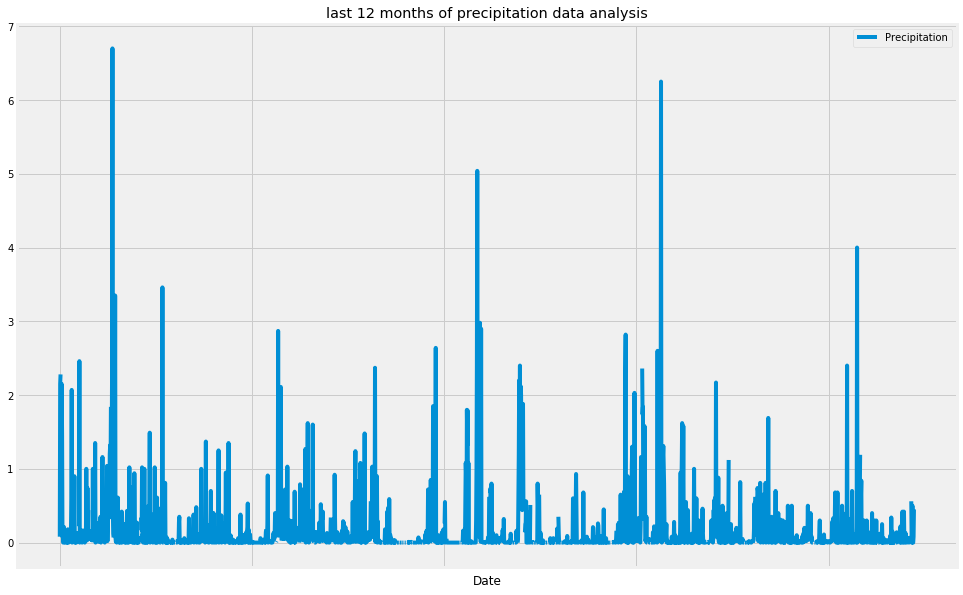

In [19]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot('date','prcp')
plt.xlabel("Date")
plt.title("last 12 months of precipitation data analysis")
plt.legend(["Precipitation"])
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [21]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement).group_by(Measurement.station).count()
print(stations_count)

9


In [22]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id)).group_by(Measurement.station).\
order_by(func.count(Measurement.id).desc()).all()

most_active = active_stations[0][0]
for station, count in active_stations:
    print(station,count)
print(f'Most Active Station:{most_active}')

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511
Most Active Station:USC00519281


In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),\
                     func.avg(Measurement.tobs)).filter(Measurement.station == most_active).group_by(Measurement.station)
for station,lowest_temp,highest_temp,avg_temp in temp:
    print(lowest_temp,highest_temp,avg_temp)

54.0 85.0 71.66378066378067


In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
filter(Measurement.station == most_active).\
filter(Measurement.date > year_ago).\
order_by(Measurement.date).all()

temp_df = pd.DataFrame(temperature)
temp_df.head()

,station,date,tobs
0,USC00519281,2016-08-24,77.0
1,USC00519281,2016-08-25,80.0
2,USC00519281,2016-08-26,80.0
3,USC00519281,2016-08-27,75.0
4,USC00519281,2016-08-28,73.0


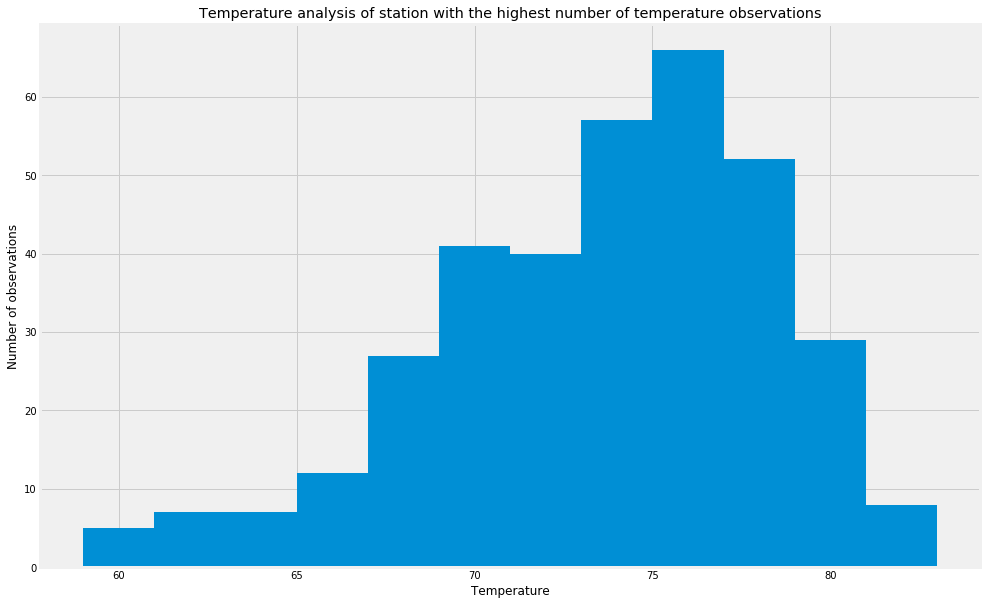

In [25]:
plt.hist(temp_df['tobs'],12)
plt.xlabel("Temperature")
plt.ylabel("Number of observations")
plt.title("Temperature analysis of station with the highest number of temperature observations")
plt.show()

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [38]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps_2011 = calc_temps('2011-02-28','2011-03-05')
temps_2011

[(61.0, 69.75510204081633, 75.0)]

In [42]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
calc_temps_df = pd.DataFrame(temps_2011,columns=['tmin','tavg','tmax'])
calc_temps_df

,tmin,tavg,tmax
0,61.0,69.755102,75.0


In [60]:
from matplotlib.pyplot import figure

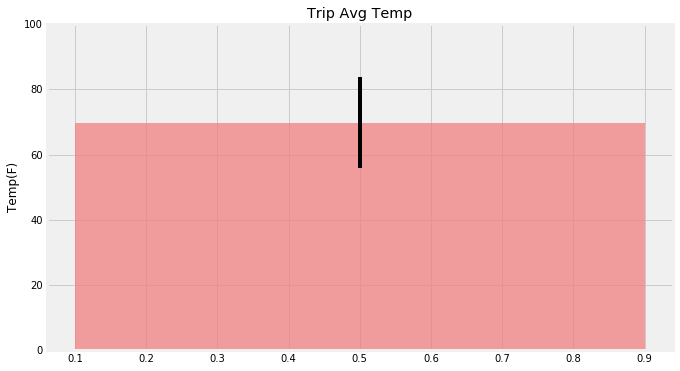

In [82]:
error = calc_temps_df['tmax'] - calc_temps_df ['tmin']
plt.bar(0.5,calc_temps_df['tavg'], yerr = error, color = 'lightcoral', alpha=0.75)
plt.ylabel("Temp(F)")
plt.title("Trip Avg Temp")
plt.ylim(0,100)
plt.rc('figure', figsize=(10, 6))
plt.show()

In [87]:
rainfall = session.query(Measurement.station,Measurement.date,Measurement.prcp, Measurement.tobs).\
filter(Measurement.date >= ).\
filter(Measurement.date <= ).\
order_by(Measurement.station).all()

TypeError: an integer is required (got type str)

In [19]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.31), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.25), ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 0.1), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.060000000000000005), ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 0.0), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.0), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.0), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)]


## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


,tmin,tavg,tmax
date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


<IPython.core.display.Javascript object>


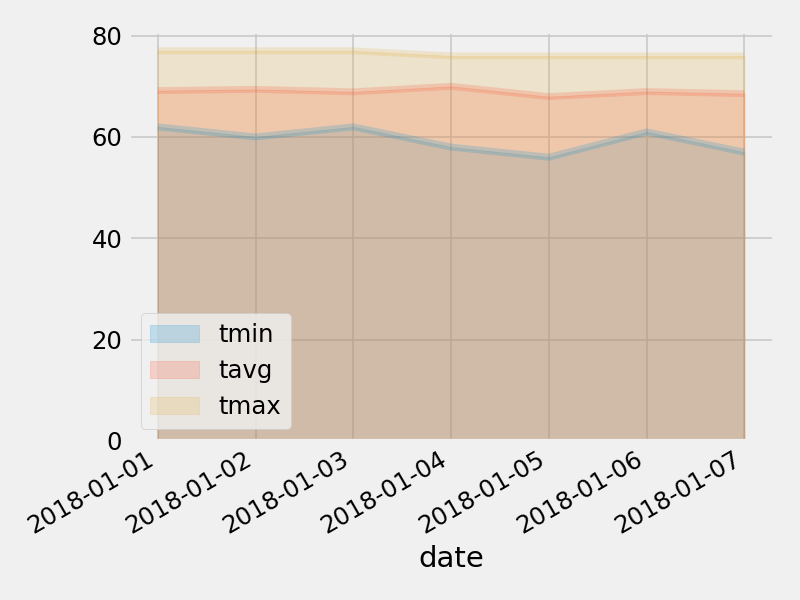

In [23]:
# Plot the daily normals as an area plot with `stacked=False`
